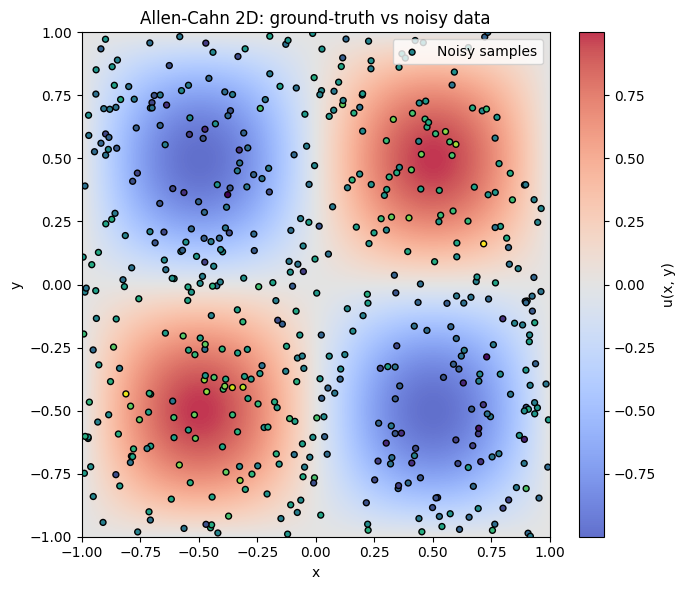

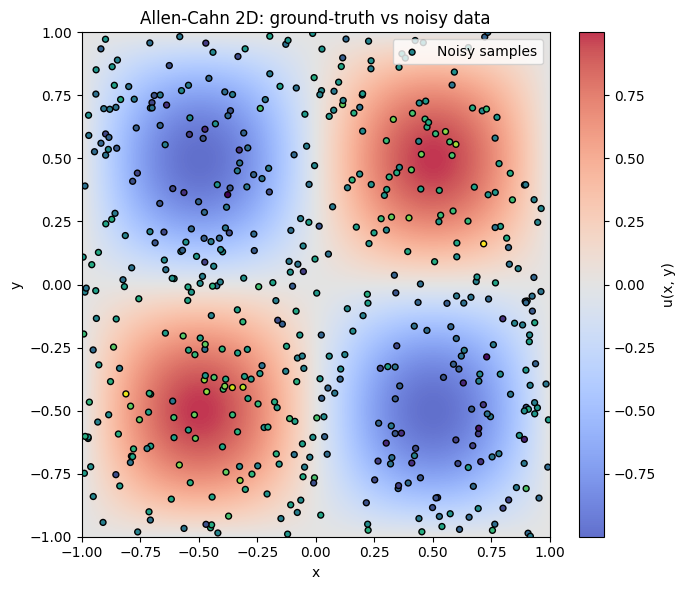

In [1]:
# ────────────────────────────────────────────────────────────────────────────────
# 0. Imports & reproducibility
# ────────────────────────────────────────────────────────────────────────────────
import math, random, numpy as np, torch
from torch import nn

torch.set_num_threads(4)
seed = 12345
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# ────────────────────────────────────────────────────────────────────────────────
# 1. Ground-truth PDE setup 
# ────────────────────────────────────────────────────────────────────────────────
from utils_pde.utils_pde_allencahn2d import AllenCahn2D

# 1) keep the torch-based definition
def true_solution(xy):
    return torch.sin(math.pi*xy[...,0:1]) * torch.sin(math.pi*xy[...,1:2])

domain=((-1.0, 1.0), (-1.0, 1.0))
pde = AllenCahn2D(lam=0.05, domain=domain, true_solution=true_solution)

# ────────────────────────────────────────────────────────────────────────────────
# 2. Data Generation (Noisy data for training, test, calibration)
# ────────────────────────────────────────────────────────────────────────────────
colloc_pt_num = 1000  # Number of collocation points

data_noise = 0.5
N_train = 500
N_test = 200
N_calib = 200

X_train, Y_train = pde.data_generation(N_train, data_noise)
X_test, Y_test = pde.data_generation(N_test, data_noise)
X_calibration, Y_calibration = pde.data_generation(N_calib, data_noise)

alphas = torch.linspace(0.05, 0.99, 10)

# Dense grid for nice plotting
def make_dense_grid(domain, N=200):
    x = np.linspace(domain[0][0], domain[0][1], N)
    y = np.linspace(domain[1][0], domain[1][1], N)
    X, Y = np.meshgrid(x, y)
    XY_grid = np.stack([X.ravel(), Y.ravel()], axis=-1)
    return XY_grid, X, Y

grid_test, X_mesh, Y_mesh = make_dense_grid(domain, 200)
grid_test_torch = torch.tensor(grid_test, dtype=torch.float32)
U_true_grid = true_solution(grid_test_torch).numpy().reshape(X_mesh.shape)


# ────────────────────────────────────────────────────────────────────────────────
# 3. Visualization: Plot ground-truth & noisy data
# ────────────────────────────────────────────────────────────────────────────────

import matplotlib.pyplot as plt

def plot_truth_and_samples_2D(
    X_train, Y_train, grid, U_true_grid, domain,
    title="Allen-Cahn 2D: ground-truth vs noisy data"
):
    fig, ax = plt.subplots(figsize=(7, 6))
    # Show the true solution as a colormap
    x = np.linspace(domain[0][0], domain[0][1], U_true_grid.shape[0])
    y = np.linspace(domain[1][0], domain[1][1], U_true_grid.shape[1])
    im = ax.imshow(
        U_true_grid,
        extent=(domain[0][0], domain[0][1], domain[1][0], domain[1][1]),
        origin='lower',
        aspect='auto',
        alpha=0.8,
        cmap='coolwarm'
    )
    # Overlay noisy training points
    ax.scatter(X_train[:,0], X_train[:,1], c=Y_train, edgecolor='k', cmap='viridis', s=18, label="Noisy samples")
    plt.colorbar(im, ax=ax, label="u(x, y)")
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_truth_and_samples_2D(
    X_train, Y_train, grid_test, U_true_grid, domain,
    title="Allen-Cahn 2D: ground-truth vs noisy data"
)


# 4) plot again
grid_test, X_mesh, Y_mesh = make_dense_grid(domain, 200)
grid_test_torch = torch.tensor(grid_test, dtype=torch.float32)
U_true_grid = true_solution(grid_test_torch).numpy().reshape(X_mesh.shape)

plot_truth_and_samples_2D(
    X_train, Y_train, grid_test, U_true_grid, domain,
    title="Allen-Cahn 2D: ground-truth vs noisy data"
)


In [ ]:
# Basic
import torch
import math
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import numpy as np
from numpy import random
torch.set_num_threads(4)

# PDEi
from utils_pde.utils_pde_2dpoisson import Poisson2D

# Viz
from utils_tools.utils_result_viz import plot_predictions_2D

# Base Mdoels
from utils_uqmd.utils_uq_dropout import DropoutPINN
from utils_uqmd.utils_uq_mlp import MLPPINN
from utils_uqmd.utils_uq_vi import VIBPINN

# CP
from utils_uqmd.utils_uq_cp import CP


# --------------------------------------------
# Build base model
# --------------------------------------------

do_pinn = DropoutPINN(
    pde_class=pde, 
    input_dim=2,
    hidden_dims=[16, 32, 64, 64, 64, 32, 16], 
    output_dim=1, 
    p_drop=0.1
)

# --------------------------------------------
# Define tuning arguments
# --------------------------------------------

# Base Model
fit_args = {
    "coloc_pt_num":colloc_pt_num,
    "X_train":X_train, 
    "Y_train":Y_train
}
# Change the parameter grids to test
fit_kwargs_grid = {
    "epochs":[30000],
    "λ_pde":[3.0, 5.0], "λ_bc":[5.0, 10.0], "λ_data":[1.0, 2.0, 5.0],  # Change based on baseline model
    "lr":[1e-3, 3e-4],
    # "scheduler_cls":[StepLR], "scheduler_kwargs":[{'step_size': 5000, 'gamma': 0.5}],
    "stop_schedule":[10000, 20000, 40000]
}

baseline_pred_kwargs = {  # Change all the kwargs here
    "n_samples":100 
}

# CP Model
cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":"raw_std",
        "k":10
}

cp_coverage_args = {
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":"raw_std", # Change base on if the baseline model has its original uq band
    "k":1
}

baseline_coverage_args = { 
    "uqmodel":do_pinn,   # Change this
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test,
    "n_samples":100
}


# --------------------------------------------
# Defining Plotting Grid
# --------------------------------------------
n_grid = 100
x = torch.linspace(domain[0][0],domain[0][1], n_grid)
y = torch.linspace(domain[1][0],domain[1][1], n_grid)
X, Y = torch.meshgrid(x, y, indexing='xy')
grid_test = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)


# --------------------------------------------
# Start hyperparameter tuning 
# --------------------------------------------
from utils_tools.utils_tuning import hyperparameter_tuning
from utils_tools.utils_result_viz import plot_2D_comparison_with_coverage
from utils_uqmd.utils_uq_cp import CP
from utils_tools.utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties, do_test_uncertainties

hyperparameter_tuning(
    plot_title="Dopout CP Model", # Change this
    # Model Fitting & Predicting
    uqmodel=do_pinn,  # Change this
    alpha=0.05, 
    X_test=grid_test, Y_test=Y_test, 
    fit_args=fit_args, fit_kwargs_grid=fit_kwargs_grid, baseline_pred_kwargs=baseline_pred_kwargs, cp_pred_kwargs=cp_pred_kwargs, 
    true_solution=pde.true_solution,
    # Coverage Test
    baseline_coverage_args=baseline_coverage_args, cp_coverage_args=cp_coverage_args,
    baseline_test_uncertainties=do_test_uncertainties, # Change this
    # Plotting function
    plotting_func=plot_2D_comparison_with_coverage, # 
    save_dir="2dallencahn_do_cp", # Change this
    X_validation=X_test, Y_validation=Y_test
)

Using device: cpu
Using device: cpu

[🔎] Trying: {'epochs': 30000, 'λ_pde': 3.0, 'λ_bc': 5.0, 'λ_data': 1.0, 'lr': 0.001, 'stop_schedule': 10000}

[🟠] Training...
ep     1 | L=2.10e+00 | data=4.91e-01 | pde=5.28e-01  ic=0.00e+00  bc=5.14e-03 | lr=1.00e-03
ep   500 | L=8.89e-01 | data=3.11e-01 | pde=1.38e-01  ic=0.00e+00  bc=3.30e-02 | lr=1.00e-03
ep  1000 | L=7.89e-01 | data=3.16e-01 | pde=1.16e-01  ic=0.00e+00  bc=2.48e-02 | lr=1.00e-03
ep  1500 | L=6.88e-01 | data=3.04e-01 | pde=8.76e-02  ic=0.00e+00  bc=2.43e-02 | lr=1.00e-03
ep  2000 | L=6.53e-01 | data=2.89e-01 | pde=8.88e-02  ic=0.00e+00  bc=1.95e-02 | lr=1.00e-03
ep  2500 | L=6.49e-01 | data=2.96e-01 | pde=8.47e-02  ic=0.00e+00  bc=1.99e-02 | lr=1.00e-03
ep  3000 | L=6.14e-01 | data=2.88e-01 | pde=7.86e-02  ic=0.00e+00  bc=1.81e-02 | lr=1.00e-03
ep  3500 | L=5.95e-01 | data=2.85e-01 | pde=7.12e-02  ic=0.00e+00  bc=1.94e-02 | lr=1.00e-03
ep  4000 | L=5.86e-01 | data=2.90e-01 | pde=7.23e-02  ic=0.00e+00  bc=1.59e-02 | lr=1.00e-03


/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)



[🟠] Computing Coverage...


100%|██████████| 10/10 [00:01<00:00,  7.94it/s]



[✅] Data Loss = 2.437e-01

[🔎] Trying: {'epochs': 30000, 'λ_pde': 3.0, 'λ_bc': 5.0, 'λ_data': 1.0, 'lr': 0.001, 'stop_schedule': 20000}

[🟠] Training...
ep     1 | L=5.28e-01 | data=2.83e-01 | pde=6.41e-02  ic=0.00e+00  bc=1.06e-02 | lr=1.00e-03
ep   500 | L=5.37e-01 | data=2.86e-01 | pde=6.57e-02  ic=0.00e+00  bc=1.08e-02 | lr=1.00e-03
